In [60]:
import yfinance as yf
import pandas as pd
from scipy.signal import argrelextrema
import numpy as np

# nasdaq
data = yf.download('^IXIC', period = "720d", interval = "60m")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-06-19 09:30:00-04:00,7968.989746,7972.965332,7936.630371,7944.499512,7944.499512,0
2019-06-19 10:30:00-04:00,7945.280762,7957.340820,7941.850586,7957.340820,7957.340820,215040340
2019-06-19 11:30:00-04:00,7957.527344,7959.328125,7949.914551,7953.916016,7953.916016,0
2019-06-19 12:30:00-04:00,7952.694336,7952.819336,7938.839844,7944.821289,7944.821289,935402493
2019-06-19 13:30:00-04:00,7944.831055,7995.502930,7930.381836,7957.520508,7957.520508,216550939


In [61]:
def setExtrema(data):
    n = 20

    data['minextrema'] = data.iloc[argrelextrema(data.Close.values, np.less_equal,
                        order=n)[0]]['Close']
    data['maxextrema'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal,
                            order=n)[0]]['Close']
    return data

data = setExtrema(data)

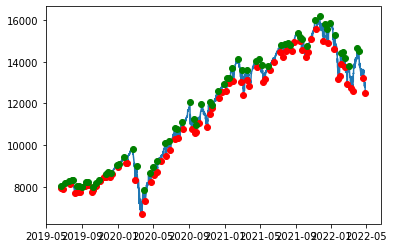

In [62]:
import matplotlib.pyplot as plt

plt.plot(data.Close)
plt.plot(data.minextrema, 'ro')
plt.plot(data.maxextrema, 'go')

In [63]:
# mark signal high or low 
data['signal'] = None
last = None
for i in range(len(data)):
    if data.minextrema[i] == data.Close[i]:
        last = 1
    elif data.maxextrema[i] == data.Close[i]:
        last = 0 # -1
    data.signal[i] = last


## add ta signals
from ta import add_all_ta_features
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume")
data["signal"] = data.signal.fillna(method='ffill')
data = data.fillna(method='ffill')
data.replace(np.inf, 999, inplace=True)
data.replace(-np.inf, -999, inplace=True)
data = data.fillna(1)
print(data.signal.value_counts())

/tmp/ipykernel_6090/2584197674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.signal[i] = last
/home/jguese/miniconda3/lib/python3.10/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/home/jguese/miniconda3/lib/python3.10/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/home/jguese/miniconda3/lib/python3.10/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/home/jguese/miniconda3/lib/python3.10/site-packages/ta/trend.py:939: FutureW

1    3066
0    1957
Name: signal, dtype: int64


In [64]:
# ml start
from sklearn.model_selection import train_test_split

X = data.drop(["signal", "minextrema", "maxextrema"], axis = 1)
Y = data["signal"]

x_train, x_test, y_train, y_test = train_test_split(  X, Y, test_size=0.2, shuffle = True)

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier


# clf = make_pipeline(StandardScaler(),SGDClassifier())
clf = XGBClassifier()
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print(score)
# sgdclassifier score 0.68 without ta
# with ta 0.82
# xgbclassifier 0.96
clf.fit(X, Y)
prediction = clf.predict(X)


0.9592039800995025


# backtest best average prediction range

In [65]:
def oneSim(predlookback = 1):
    startmoney = 10000
    money = startmoney
    nrStocks = 0
    trades = []
    boughtAt = 0

    for i in range(predlookback, len(data)):
        pred = np.median(prediction[i-predlookback:i])
        crntPrice = data.Close[i]
        if pred == 1 and money > 10:
            # buy
            howmany = money / crntPrice * .95
            cost = howmany * crntPrice * (1.00025) # comission
            money = money - cost
            nrStocks = nrStocks + howmany
            boughtAt = cost
        elif pred == 0 and nrStocks > 0:
            # sell
            cost = nrStocks * crntPrice * (0.99975) # comission
            money = money + cost
            nrStocks = 0
            trades.append(cost - boughtAt)
    # last day need to sell open positions
    if nrStocks >0:
        cost = nrStocks * crntPrice * (0.99975) # comission
        money = money + cost
        nrStocks = 0
        trades.append(cost - boughtAt)
    return money, trades

money, trades = oneSim()
print("win is: ", money)
print("trades stats howmany, mean, median, std: ", len(trades), np.mean(trades), np.median(trades), np.std(trades))

win is:  176637.96953606434
trades stats howmany, mean, median, std:  61 61843.04816209569 47015.91189928691 50376.11500713492


In [68]:
# for i in [1,3,5,10,15]:
#     money, trades = oneSim(i)
#     print(i, "win is: ", money)
#     print(i, "trades stats howmany, mean, median, std: ", len(trades), np.mean(trades), np.median(trades), np.std(trades))

1 win is:  176637.96953606434
1 trades stats howmany, mean, median, std:  61 61843.04816209569 47015.91189928691 50376.11500713492
3 win is:  133948.90801366302
3 trades stats howmany, mean, median, std:  61 51575.920702731186 41286.95554540937 38765.36555656537
5 win is:  105200.78806795429
5 trades stats howmany, mean, median, std:  61 43817.767883374865 36036.62802492813 30514.141698285952
10 win is:  50126.82835838963
10 trades stats howmany, mean, median, std:  59 25477.404770486573 21522.774806712823 13438.40587697197
15 win is:  33610.23372639824
15 trades stats howmany, mean, median, std:  52 20561.457872251838 20219.801398054828 8360.381776495204


# just working with the first prediction is best.

In [67]:
# calculate monthly win

days = len(data)
months = days / 30
winPerMonth = money / months
winPctMonth = winPerMonth / 10000
print("win per month: ", winPerMonth)
print("win pct per month: ", winPctMonth)

# daily stuff
# win per month:  752.6707763201679
# win pct per month:  0.07526707763201679

win per month:  1054.9749325267628
win pct per month:  0.10549749325267628
